# Wzy Linkage Associative Statistics

## Setup

### Define file paths

In [15]:
from pathlib import Path
parent_path = Path('/Users/tsta0015/Programming/Wzy_Analysis')
jk_path = parent_path / 'from_JK'
pc_path = jk_path / 'ProteinCartography'
result_path = parent_path / 'results'
linkage_data_path = jk_path / 'Acinetobacter_Wzy.xlsx'
pc_cluster_path = pc_path / 'final_results' / 'Wzy_Ab_only_Ph2_tom2025_aggregated_features.tsv'

### Load data

#### Load Wzy _A. baumannii_ linkage data

In [16]:
import pandas as pd
linkage_data = pd.read_excel(linkage_data_path, engine='calamine', index_col=0).drop(
    columns=[
        'Leiden cluster', 'Genus/species/complex', 'NCBI accession no.',
        'NCBIfam (Interproscan)', 'Pfam (Interproscan)', 'PANTHER (Interproscan)', 'Structure 1', 'Structure 2', 'SMILES'
    ]
)
linkage_data.index = linkage_data.index.str.lower()

?#### Load Wzy _A. baumannii_ ProteinCartography clusters

In [17]:
import pandas as pd
clusters = pd.read_csv(pc_cluster_path, nrows=244, sep='\t', index_col=0).drop(
    columns=['pdb_origin', 'pdb_confidence', 'pdb_chains', 'Protein names', 'StruCluster'])
clusters.index = clusters.index.str.removesuffix('_model')

### Prepare data

Check difference between the clusters and linkage data - remember we may not have 3D protein structures for everything so we can't perform associative stats on missing data...

In [18]:
linkage_data.index.difference(clusters.index)

Index(['abaumannii_kl24', 'abaumannii_ph3', 'abaumannii_ph4'], dtype='object')

Clusters for abaumannii_kl24 abaumannii_ph3 and abaumannii_ph4 are missing because we didn't model these, therefore we can't perform associative stats on these...

#### Merge data

In [19]:
linkage_data = linkage_data.join(clusters, how='inner')

#### Add extra substrate data

We define "Substrate set" as the combination of donor and acceptor substrate sorted alphabetically (donor/acceptor agnostic)

In [20]:
linkage_data['Substrate set'] = linkage_data[
    ['Donor substrate', 'Acceptor substrate']].apply(
    lambda x: ' '.join(sorted(x)), axis=1)

We define "Linkage" as the ordered combination of donor, carbons and acceptor.

In [21]:
linkage_data['Linkage'] = linkage_data[
    ['Donor substrate', 'Carbon positions', 'Acceptor substrate']].apply(
    lambda x: '-'.join(x), axis=1)

## Stats

#### Load statistics helper function

In [8]:
from stats_helpers import StatHelper
helper = StatHelper(linkage_data)
cluster_col = "Assigned cluster"

In [9]:
print("--- 1. Anomeric Configuration (One vs One) ---")
# Chi2 Omnibus
print(helper.run_omnibus_chi2(cluster_col, "Anomeric configuration"))
# Fisher Pairwise (A vs B, B vs C...)
print(helper.run_pairwise_categorical(cluster_col, "Anomeric configuration", mode='one_vs_one'))
print("\n")

--- 1. Anomeric Configuration (One vs One) ---
{'Test': 'Chi2 Omnibus', 'Feature': 'Anomeric configuration', 'P-value': np.float64(3.1391327920480635e-17), 'Dof': 2}
     Comparison Feature  Count_G1  Count_G2       P_value         P_adj
4  WzyB vs WzyA       b         0        44  5.096911e-17  1.529073e-16
5  WzyB vs WzyA       a        20         0  5.096911e-17  1.529073e-16
0  WzyC vs WzyB       b        12         0  4.428838e-09  6.643258e-09
1  WzyC vs WzyB       a         0        20  4.428838e-09  6.643258e-09
2  WzyC vs WzyA       b        12        44  1.000000e+00  1.000000e+00
3  WzyC vs WzyA       a         0         0  1.000000e+00  1.000000e+00




In [10]:
print("--- 2. Linkages (One vs Rest, n > 5 because the sample dataset is small) ---")
print(helper.run_pairwise_categorical(cluster_col, "Linkage", mode='one_vs_rest', min_obs=5))
print("\n")

--- 2. Linkages (One vs Rest, n > 5 because the sample dataset is small) ---
  Group               Feature  In_Group_Count  Out_Group_Count   P_value  \
4  WzyA  D-GalpNAc-1,3-D-Galp              10                0  0.003960   
5  WzyA  D-GlcpNAc-1,3-L-Rhap               7                0  0.019068   
2  WzyB  D-GalpNAc-1,3-D-Galp               0               10  0.054682   
3  WzyB  D-GlcpNAc-1,3-L-Rhap               0                7  0.179465   
0  WzyC  D-GalpNAc-1,3-D-Galp               0               10  0.347725   
1  WzyC  D-GlcpNAc-1,3-L-Rhap               0                7  0.588465   

      P_adj  
4  0.023760  
5  0.057204  
2  0.109364  
3  0.269198  
0  0.417270  
1  0.588465  




In [11]:
print("--- 3. Substrate Set (One vs Rest, n > 5) ---")
print(helper.run_pairwise_categorical(cluster_col, "Substrate set", mode='one_vs_rest', min_obs=5))
print("\n")

--- 3. Substrate Set (One vs Rest, n > 5) ---
   Group              Feature  In_Group_Count  Out_Group_Count   P_value  \
4   WzyB     D-Galp D-GalpNAc               0               17  0.003841   
8   WzyA     D-Galp D-GalpNAc              13                4  0.098763   
0   WzyC     D-Galp D-GalpNAc               4               13  0.449125   
1   WzyC  D-GlcpNAc D-GlcpNAc               0                9  0.339395   
6   WzyB     D-GlcpNAc L-Rhap               1                8  0.430896   
10  WzyA     D-GlcpNAc L-Rhap               7                2  0.288235   
11  WzyA  D-GalpNAc D-GlcpNAc               5                1  0.391532   
3   WzyC  D-GalpNAc D-GlcpNAc               0                6  0.581490   
5   WzyB  D-GlcpNAc D-GlcpNAc               3                6  0.690704   
9   WzyA  D-GlcpNAc D-GlcpNAc               6                3  0.725881   
2   WzyC     D-GlcpNAc L-Rhap               1                8  1.000000   
7   WzyB  D-GalpNAc D-GlcpNAc             

In [12]:
print("--- 4. Unit Lengths (Kruskal + MWU) ---")
omnibus, pairwise = helper.run_numerical_distributions(cluster_col, "Length")
print("Omnibus:", omnibus)
print("Pairwise:")
print(pairwise)

--- 4. Unit Lengths (Kruskal + MWU) ---
Omnibus: {'Test': 'Kruskal-Wallis', 'Statistic': np.float64(36.1988580409633), 'P-value': np.float64(1.378852626780942e-08)}
Pairwise:
     Comparison  Median_1  Median_2       P_value         P_adj
0  WzyC vs WzyB     383.0     435.5  1.498350e-03  1.498350e-03
1  WzyC vs WzyA     383.0     346.0  1.014646e-03  1.498350e-03
2  WzyB vs WzyA     435.5     346.0  5.751513e-08  1.725454e-07


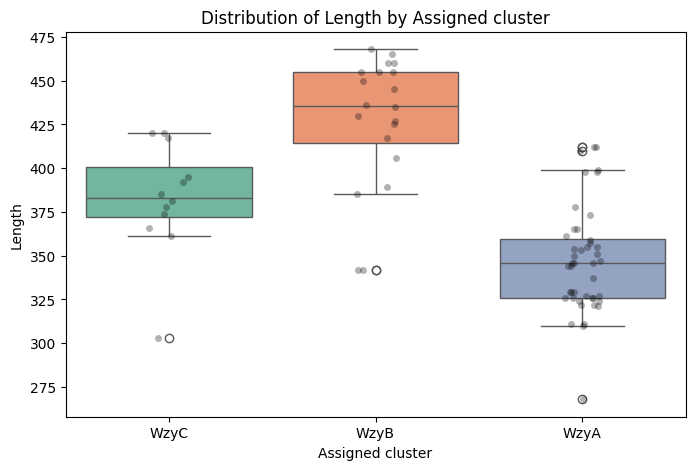

In [13]:
helper.plot_distributions(cluster_col, "Length")

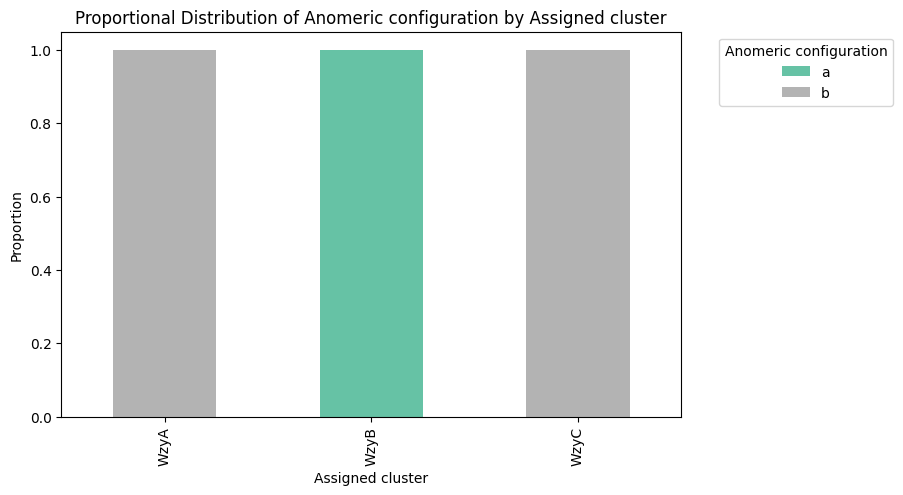

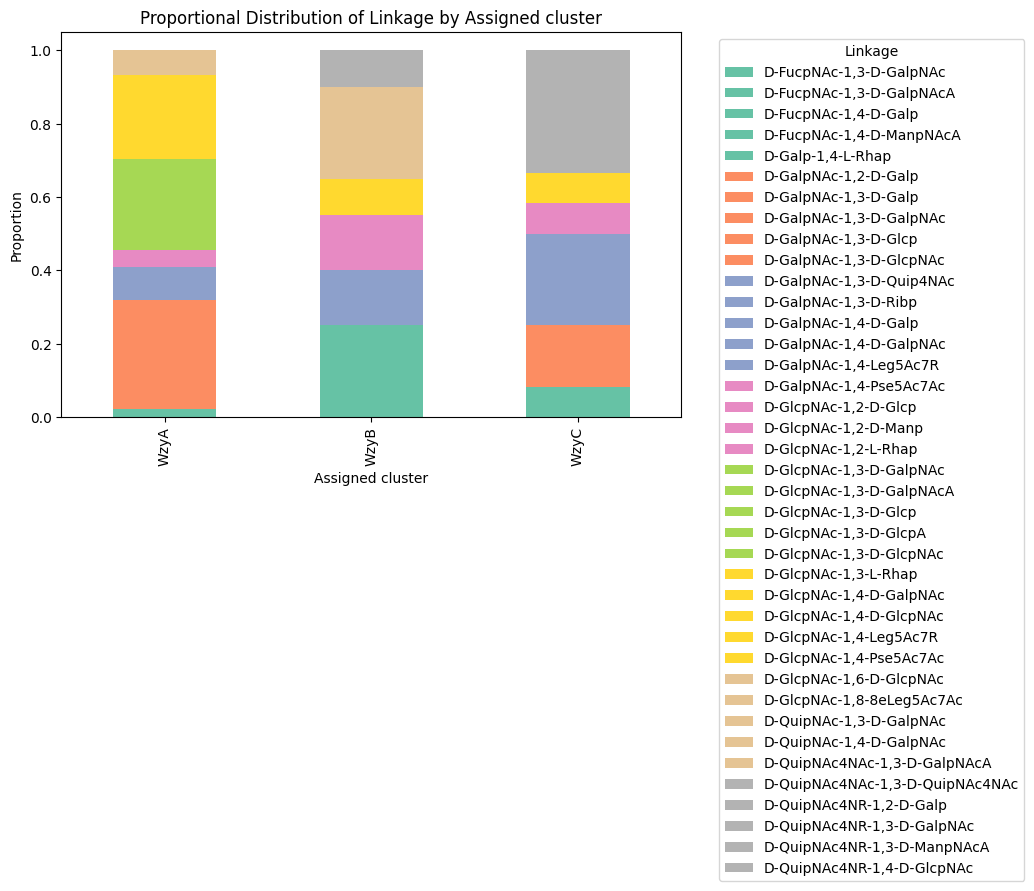

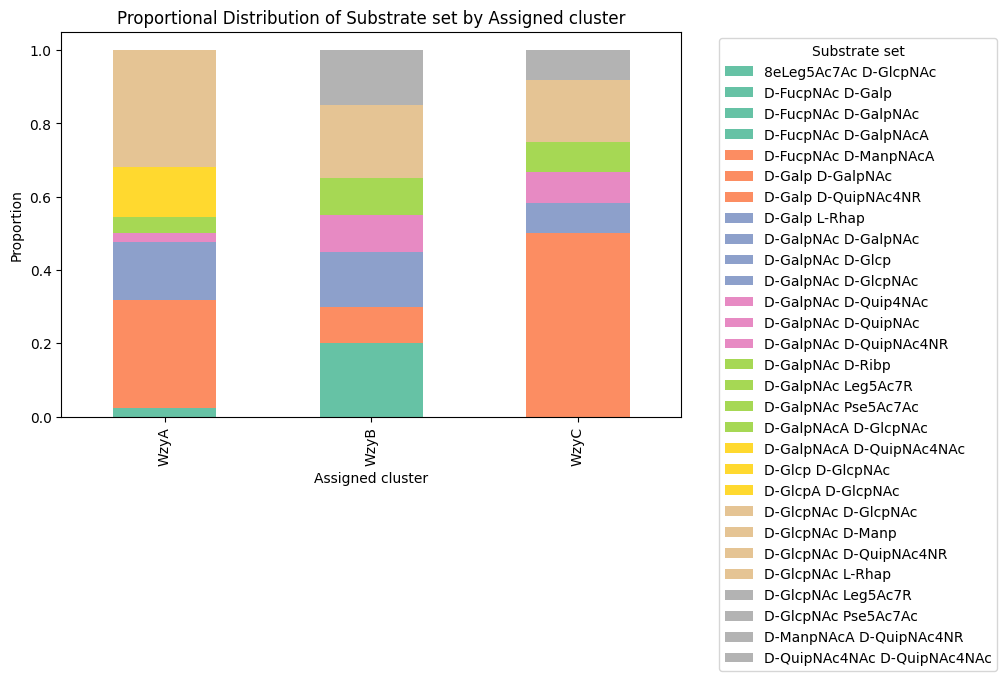

In [14]:
helper.plot_categorical_association(cluster_col, "Anomeric configuration")
helper.plot_categorical_association(cluster_col, "Linkage")
helper.plot_categorical_association(cluster_col, "Substrate set")